In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from Encoder import Encoder, reparameterize
from Generator import Generator
from Discriminator import BigJointDiscriminator

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
class InvertiblePriorLinear(nn.Module):
    def __init__(self):
        super(InvertiblePriorLinear, self).__init__()
        self.p = nn.Parameter(torch.rand([2]))
        
    def forward(self, eps):
        o = self.p[0] * eps + self.p[1]
        return o
    def inverse(self, o):
        eps = (o - self.p[1])/self.p[0]
        return eps

class InvertiblePriorInv(nn.Module):
    """docstring for InvertiblePrior"""
    def __init__(self,prior):
        super(InvertiblePriorInv, self).__init__()
        self.prior = prior
    def forward(self, o):
        return self.prior.inverse(o)
    def inverse(self, eps):
        return self.prior(eps)


class SCM(nn.Module):
    def __init__(self, d, A=None, scm_type='mlp'):
        super().__init__()
        self.d = d
        self.A_given = A
        self.A_fix_idx = A == 0
        self.A = nn.Parameter(torch.zeros(d, d))

        prior_net_model = lambda : InvertiblePriorLinear()
        prior_net_enc_model = lambda x: InvertiblePriorInv(x)
        
        for i in range(d):
            setattr(self, "prior_net%d" % i, prior_net_model())
            setattr(self, "enc_net%d" % i, prior_net_enc_model(getattr(self, "prior_net%d" % i)))

    def set_zero_grad(self):
        if self.A_given is None:
            pass
        else:
            for i in range(self.d):
                for j in range(self.d):
                    if self.A_fix_idx[i, j]:
                        self.A.grad.data[i, j].zero_()

    def prior_nlr(self, z):
        '''Nonlinear transformation f_2(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "prior_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def enc_nlr(self, z):
        '''f_2^{-1}(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "enc_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def mask(self, z): # Az
        z = torch.matmul(z, self.A)
        return z

    def inv_cal(self, eps): # (I-A)^{-1}*eps
        adj_normalized = torch.inverse(torch.eye(self.A.shape[0], device=self.A.device) - self.A)
        z_pre = torch.matmul(eps, adj_normalized)
        return z_pre

    def get_eps(self, z):
        '''Returns epsilon from f_2^{-1}(z)'''
        return torch.matmul(z, torch.eye(self.A.shape[0], device=self.A.device) - self.A)

    def intervene(self, z, z_ori):
        # f_2^{-1}(z)
        z_ori = self.enc_nlr(z_ori)
        z = self.enc_nlr(z)
        # masked nonlinear z
        z_new = self.mask(z)
        z_new = z_new + self.get_eps(z_ori)
        return self.prior_nlr(z_new)

    def forward(self, eps=None, z=None):
        if eps is not None and z is None:
            # (I-A.t)^{-1}*eps
            z = self.inv_cal(eps) # n x d
            # nonlinear transform
            return self.prior_nlr(z)
        else:
            # f_2^{-1}(z)
            z = self.enc_nlr(z)
            # mask z
            z_new = self.mask(z) # new f_2^{-1}(z) (without noise)
            return z_new, z

In [4]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/'

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        _ = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]    
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

def get_train_dataloader(root_folder, img_dim=64, batch_size=32, cols = None):

    transform = Compose([Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    training_data = ImageDataset(root_folder='sample_data/',transform=transform, cols = cols)
    train_dataloader = DataLoader(training_data, batch_size = batch_size)
    return train_dataloader

In [5]:
cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']

In [6]:
root_folder = 'sample_data/'

in_channels = 3
fc_size = 2048
latent_dim = 100

img_dim = 64
batch_size = 128

num_label = len(cols)

In [7]:
train_dataloader = get_train_dataloader(root_folder, img_dim=img_dim, batch_size=batch_size, cols = cols)

In [8]:
A = torch.zeros((num_label, num_label), device = device)
A[0, 2:6] = 1
A[1, 4] = 1

In [9]:
prior = SCM(num_label, A, scm_type='linscm').to(device)
prior_param = list(prior.parameters())

In [10]:
e = Encoder(latent_dim = latent_dim, fc_size = fc_size).to(device)
g = Generator(latent_dim = latent_dim, image_size = img_dim).to(device)
disc = BigJointDiscriminator(latent_dim = latent_dim, image_size = img_dim).to(device)

In [11]:
A_optimizer = optim.Adam(prior_param[0:1], lr=5e-4)
p_optimizer = optim.Adam(prior_param[1:],  lr=5e-4, betas=(0, 0.999))

In [12]:
e_optimizer = optim.Adam(e.parameters(), lr=5e-5, betas=(0, 0.999))
g_optimizer = optim.Adam(g.parameters(), lr=5e-5, betas=(0, 0.999))
d_optimizer = optim.Adam(disc.parameters(), lr=1e-4, betas=(0, 0.999))

In [20]:
num = len(train_dataloader.dataset)//batch_size

epochs = 10

In [14]:
disc_steps = 1
g_steps = 1
e_steps = 1

celoss = torch.nn.BCEWithLogitsLoss()

In [21]:
for epoch in tqdm(range(epochs)):
    disc_loss, e_loss, g_loss = [], [], []
    
    e.train()
    g.train()
    disc.train()
    with torch.autograd.set_detect_anomaly(True):
        for (X, label) in tqdm(train_dataloader, total = num):        
            X = X.to(device)

            sup_flag = label[:, 0] != 0
            if sup_flag.sum() > 0:
                label = label[sup_flag, :].float()
            label = label.to(device)

            for _ in range(disc_steps):
                disc.zero_grad()

                z = torch.randn(X.shape[0], latent_dim, device=device)

                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)

                e_score = disc(X, z_fake.detach())
                g_score = disc(X_fake.detach(), z.detach())

                del z_fake
                del X_fake

                loss_d = F.softplus(g_score).mean() + F.softplus(-e_score).mean()
                loss_d.backward()
                d_optimizer.step()
                disc_loss.append(loss_d.item())

            #___________________________________
            for _ in range(e_steps):
                g.zero_grad()
                e.zero_grad()
                prior.zero_grad()
                
                z = torch.randn(X.size(0), latent_dim, device=device, requires_grad = False)
                
                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                e_score = disc(X, z_fake)
                l_encoder = e_score.mean()

                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)
                label_z = mu[sup_flag, :num_label]
                sup_loss = celoss(label_z, label)

                l_encoder = l_encoder + sup_loss * 5
                l_encoder.backward()

                e_loss.append(l_encoder.item())
                e_optimizer.step()
                p_optimizer.step()
                
                ## Generator 
                z = torch.randn(X.size(0), latent_dim, device=device, requires_grad = False)            
                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)
                g_score = disc(X_fake, z)
                s_decoder = torch.exp(g_score.detach()).clamp(0.5, 2)
                loss_decoder = -(s_decoder * g_score).mean()
                g_loss.append(loss_decoder.item())
                loss_decoder.backward()
                g_optimizer.step()

                prior.set_zero_grad()
                A_optimizer.step()
                p_optimizer.step()
        
        print(f"[{epoch+1}/{epochs}] Encoder Loss : {sum(e_loss)/num:>.5f} Gen Loss : {sum(g_loss)/num:>.5f} Disc Loss : {sum(disc_loss)/num:>.5f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[1/10] Encoder Loss : 1.28785 Gen Loss : 0.01847 Disc Loss : 1.31280


  0%|          | 0/158 [00:00<?, ?it/s]

[2/10] Encoder Loss : 1.16427 Gen Loss : -0.00511 Disc Loss : 1.32028


  0%|          | 0/158 [00:00<?, ?it/s]

[3/10] Encoder Loss : 1.14943 Gen Loss : -0.01133 Disc Loss : 1.31841


  0%|          | 0/158 [00:00<?, ?it/s]

[4/10] Encoder Loss : 1.08941 Gen Loss : -0.02202 Disc Loss : 1.31997


  0%|          | 0/158 [00:00<?, ?it/s]

[5/10] Encoder Loss : 1.01733 Gen Loss : -0.01324 Disc Loss : 1.32061


  0%|          | 0/158 [00:00<?, ?it/s]

[6/10] Encoder Loss : 0.94641 Gen Loss : -0.00597 Disc Loss : 1.32631


  0%|          | 0/158 [00:00<?, ?it/s]

[7/10] Encoder Loss : 0.87667 Gen Loss : -0.01777 Disc Loss : 1.32877


  0%|          | 0/158 [00:00<?, ?it/s]

[8/10] Encoder Loss : 0.82026 Gen Loss : -0.03041 Disc Loss : 1.33069


  0%|          | 0/158 [00:00<?, ?it/s]

[9/10] Encoder Loss : 0.76663 Gen Loss : -0.01052 Disc Loss : 1.33157


  0%|          | 0/158 [00:00<?, ?it/s]

[10/10] Encoder Loss : 0.73593 Gen Loss : -0.01880 Disc Loss : 1.33263


In [16]:
def plot_image(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

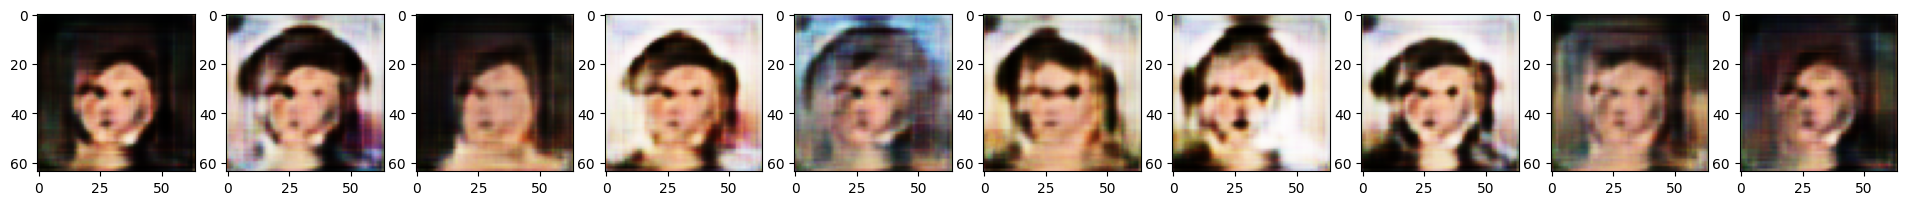

tensor([[ 1.1110, -0.1315,  4.2654,  1.5406, -0.1984,  0.4096],
        [ 2.2804,  0.1898,  5.1607,  3.4590, -0.8761, -2.1535],
        [ 1.0224, -0.7484,  0.6411,  2.1475, -0.8937, -0.0252],
        [ 1.8004, -0.3332,  5.0471,  2.6083,  1.3915, -2.2662],
        [ 2.4964,  0.3279,  6.4783,  4.0607, -2.2694, -1.8601],
        [ 1.2597, -0.6177,  1.0089,  2.2498,  0.2063,  0.6402],
        [ 1.1738,  0.2065,  2.9916,  1.5886, -0.9380,  1.1637],
        [ 1.5663,  0.0863,  4.0445,  1.6155, -0.3471, -0.0186],
        [ 0.0889,  0.5522,  4.7088,  2.3542, -0.9960, -0.8019],
        [ 3.4454, -0.3291,  5.8909,  4.5080, -2.6854, -2.1926]],
       device='cuda:0', grad_fn=<SliceBackward0>) tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1.],
        [0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
   

In [17]:
for X, label in train_dataloader:
    mu, sigma = e(X.to(device))
    z = reparameterize(mu, sigma)
    label_z = prior(z[:, :num_label])
    other_z = z[:, num_label:]
    z = torch.cat([label_z, other_z], dim=1)
    x_fake = g(z)
    x_fake = (x_fake * 0.5) + 0.5
    plot_image(x_fake)
    print(z[:10,:num_label], label[:10])
    break

In [18]:
print(A)
print(prior.A.data.to(device='cpu'))

tensor([[0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[ 0.0000,  0.0000,  0.4275,  0.4910, -0.4586, -0.4535],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.1960,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


<AxesSubplot:>

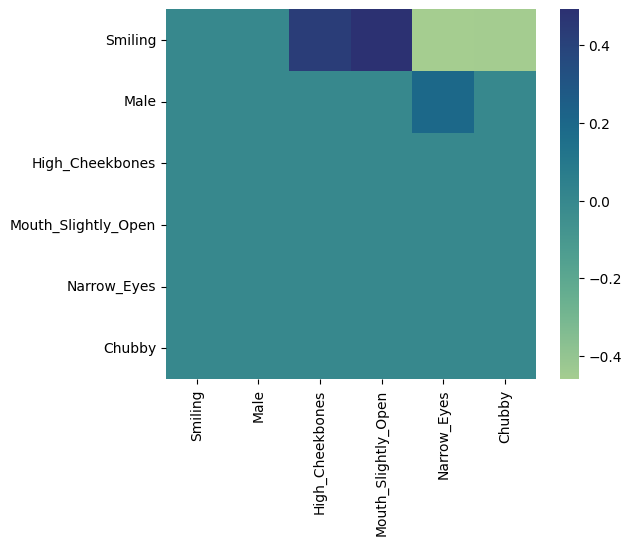

In [19]:
sns.heatmap(prior.A.data.to(device='cpu'),cmap="crest",
            square='True', xticklabels = cols, yticklabels = cols)